In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input 
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping 
import cv2
import random
import pickle
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [3]:
#data augmentation
train_data = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = .1,
    horizontal_flip = True
)
test_data = ImageDataGenerator(rescale = 1./255)

In [4]:
X_train_gen = train_data.flow_from_directory("/kaggle/input/fer2013vgg19/train/train",
                                             target_size = (48, 48),
                                             batch_size = 64,
                                             class_mode = "categorical"
                                            )
X_val = test_data.flow_from_directory("/kaggle/input/fer2013vgg19/test/test",
                                      target_size = (48, 48),
                                      batch_size = 64,
                                      class_mode = "categorical"
                                     )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(class_weight = "balanced", 
                                                 classes = np.unique(X_train_gen.classes),
                                                 y = X_train_gen.classes)
num_classes = 7
keys = range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [6]:
base_model = VGG19(
    include_top = False,
    weights = None,
    input_shape = (48, 48, 3))
base_model.load_weights("/kaggle/input/nn-vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")
#layer freeze
for layer in base_model.layers[:10]:
    layer.trainable = True

In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 7, activation = 'softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 20,057,671
Trainable params: 20,057,671
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer_1 = SGD(learning_rate = 0.01)
model.compile(optimizer = optimizer_1, loss = "categorical_crossentropy", metrics = ["acc"])

In [11]:
history = model.fit(
    X_train_gen,
    epochs = 70,
    verbose = 1,
    class_weight = class_weights,
    validation_data = X_val
)

Epoch 1/70
449/449 [==============================] - 123s 254ms/step - loss: 1.8790 - acc: 0.2310 - val_loss: 1.7911 - val_acc: 0.2959
Epoch 2/70
449/449 [==============================] - 59s 130ms/step - loss: 1.6563 - acc: 0.3575 - val_loss: 1.6806 - val_acc: 0.3647
Epoch 3/70
449/449 [==============================] - 59s 132ms/step - loss: 1.5076 - acc: 0.4236 - val_loss: 1.2661 - val_acc: 0.5187
Epoch 4/70
449/449 [==============================] - 70s 157ms/step - loss: 1.4187 - acc: 0.4609 - val_loss: 1.2162 - val_acc: 0.5348
Epoch 5/70
449/449 [==============================] - 59s 131ms/step - loss: 1.3684 - acc: 0.4790 - val_loss: 1.3210 - val_acc: 0.5000
Epoch 6/70
449/449 [==============================] - 60s 134ms/step - loss: 1.3066 - acc: 0.5003 - val_loss: 1.2759 - val_acc: 0.5194
Epoch 7/70
449/449 [==============================] - 59s 132ms/step - loss: 1.2574 - acc: 0.5145 - val_loss: 1.3022 - val_acc: 0.4978
Epoch 8/70
449/449 [==============================] - 

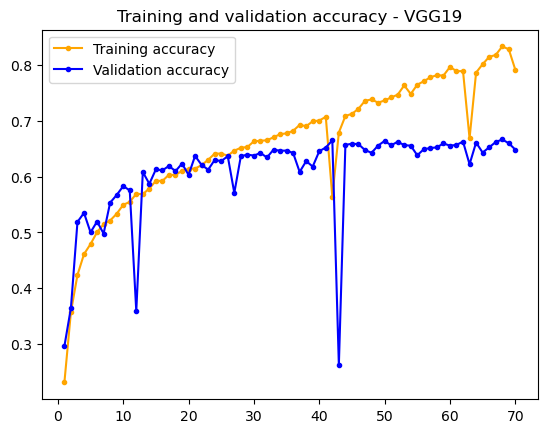

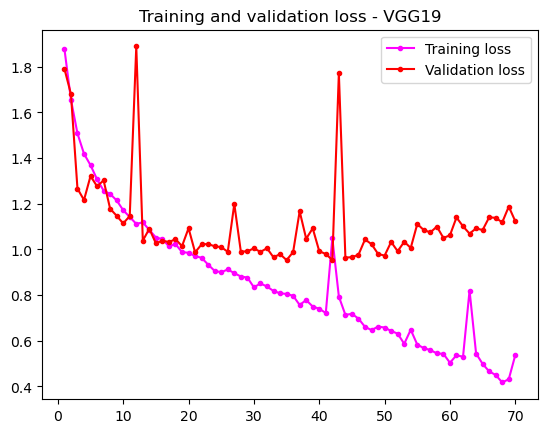

In [12]:
#history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.title('Training and validation accuracy - VGG19')
plt.plot(epochs, acc, 'orange', marker = '.', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'blue', marker = '.', label = 'Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss - VGG19')
plt.plot(epochs, loss, 'magenta', marker = '.', label = 'Training loss')
plt.plot(epochs, val_loss, 'red', marker = '.', label = 'Validation loss')
plt.legend()
plt.show()

In [2]:
from tensorflow import keras 
model.save('/kaggle/working/vgg19modelfer2013')

In [4]:
model_vgg19 = keras.models.load_model("/kaggle/working/vgg19modelfer2013")

In [17]:
#create test data
test_data = []
test_data_dir = "/kaggle/input/ferplustest/test"
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
def create_test_data():
    for cat in categories:
        path = os.path.join(test_data_dir, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (48, 48))
            test_data.append([new_array, class_num])

In [18]:
create_test_data()

In [20]:
random.shuffle(test_data)
X_test = []
y_test = []
for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)
X_test = np.array(X_test).reshape(7048, 48, 48, 3)
y_test = np.array(y_test)

In [23]:
data_path = "/kaggle/working/"
pickle_out = open(data_path + "/X_test_rgb_pickle", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

In [24]:
pickle_out = open(data_path + "/y_test_rgb_pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [25]:
X_test = X_test/255.0

221/221 [==============================] - 2s 9ms/step


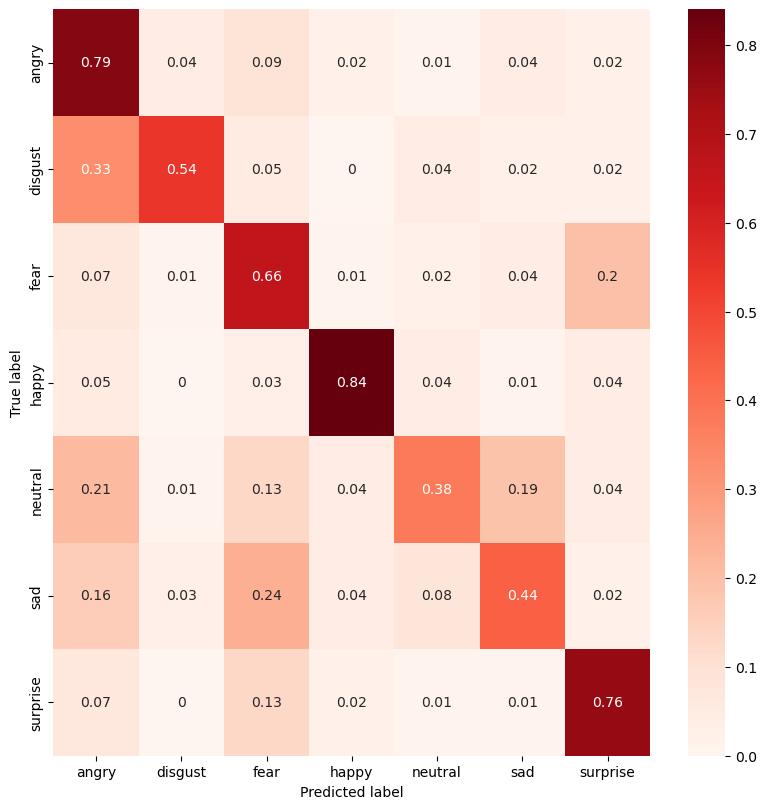

In [26]:
y_predict = model_vgg19.predict(X_test)
y_true = y_test
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis=1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
con_mat_norm = np.around(res.astype('float')/res.sum(axis=1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/kaggle/working/confusion_matrix_vgg19_1.png")
plt.show()

In [27]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
model_vgg19.evaluate(X_test, y_test)

221/221 [==============================] - 3s 11ms/step - loss: 1.4242 - acc: 0.5992


[1.4242159128189087, 0.5991770625114441]